In [ ]:
!pip install --upgrade -q google-cloud-aiplatform tensorflow -q

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
PROJECT_ID = "[PROVIDE GOOGLE CLOUD PROJECT_ID]"
! gcloud config set project $PROJECT_ID
REGION = "us-central1"

Updated property [core/project].


In [ ]:
from google.colab import auth
auth.authenticate_user()

# Tracking Parameters and Metrics

Import libraries and define constants. Loading and processing the dataset

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import aiplatform
from tensorflow.python.keras import Sequential, layers
from tensorflow.python.keras.utils import data_utils

In [ ]:
EXPERIMENT_NAME = "vertex-ai-auto-dataset-metrics-parameters-experiment"

Train a distributed neural network (DNN) model to predict automobile's miles per gallon (MPG) based on automobile information from an auto-mpg dataset.

Load and Process the Training Dataset

In [ ]:
def read_data(uri):
  dataset_path = data_utils.get_file("auto-mpg.data", uri)
  column_names = [
      "MPG",
      "Cylinders",
      "Displacement",
      "Horsepower",
      "Weight",
      "Acceleration",
      "Model Year",
      "Origin",
  ]
  raw_dataset = pd.read_csv(
      dataset_path,
      names = column_names,
      na_values = "?",
      comment = "\t",
      sep = " ",
      skipinitialspace = True,
  )
  dataset = raw_dataset.copy().dropna()
  dataset["Origin"] = dataset["Origin"].map( lambda x: {1: "USA", 2: "Europe", 3: "Japan"}.get(x))
  dataset = pd.get_dummies(dataset, prefix="", prefix_sep="")
  return dataset

dataset = read_data(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)

Split dataset for training and testing.

In [ ]:
def train_test_split(dataset, split_frac=0.8, random_state=0):
  train_dataset = dataset.sample(frac=split_frac, random_state=random_state)
  test_dataset = dataset.drop(train_dataset.index)
  train_labels = train_dataset.pop("MPG")
  test_labels = test_dataset.pop("MPG")

  return train_dataset, test_dataset, train_labels, test_labels

train_dataset, test_dataset, train_labels, test_labels = train_test_split(dataset)

Normalize the features in the dataset for better model performance.

In [ ]:
def normalize_dataset(train_dataset, test_dataset):
  train_stats = train_dataset.describe()
  train_stats = train_stats.transpose()

  def norm(x):
    return ( x - train_stats["mean"]) / train_stats["std"]

  normed_train_data = norm(train_dataset)
  normed_test_data = norm(test_dataset)

  return normed_train_data, normed_test_data

normed_train_data, normed_test_data = normalize_dataset(train_dataset, test_dataset)

Define ML model and training function

In [ ]:
def train(
    train_data,
    train_labels,
    num_units=64,
    activation="relu",
    dropout_rate=0.0,
    validation_split=0.2,
    epochs=1000,
):
    model = Sequential(
        [
            layers.Dense(
                num_units,
                activation=activation,
                input_shape=[len(train_dataset.keys())],
            ),
            layers.Dropout(rate=dropout_rate),
            layers.Dense(num_units, activation=activation),
            layers.Dense(1),
        ]
    )

    model.compile(loss="mse", optimizer="adam", metrics=["mae", "mse"])
    print(model.summary())

    history = model.fit(
        train_data, train_labels, epochs=epochs, validation_split=validation_split
    )

    return model, history

# Initialize Vertex AI SDK for Python and create and Experiment

Initialize the client for Vertex AI and create an experiment.

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION, experiment=EXPERIMENT_NAME)

# Start several model training runs

Training parameters and metrics are logged for each run.

In [ ]:
parameters = [
    {"num_units": 16, "epochs": 3,  "dropout_rate": 0.1},
    {"num_units": 16, "epochs": 10, "dropout_rate": 0.1},
    {"num_units": 16, "epochs": 10, "dropout_rate": 0.2},
    {"num_units": 32, "epochs": 10, "dropout_rate": 0.1},
    {"num_units": 32, "epochs": 10, "dropout_rate": 0.2},
]

for i, params in enumerate(parameters):
  aiplatform.start_run(run=f"auto-mpg-local-second-trial-run-{i}")
  aiplatform.log_params(params)
  model, history = train(
      normed_train_data,
      train_labels,
      num_units=params["num_units"],
      activation="relu",
      epochs=params["epochs"],
      dropout_rate=params["dropout_rate"],
  )

  for metric, values in history.history.items():
    try:
      aiplatform.log_metrics({metric: values[-1]})
    except:
      aiplatform.log_metrics({metric: 0.0})

  loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
  try:
    aiplatform.log_metrics({"eval_loss": loss, "eval_mae": mae, "eval_mse": mse})
  except:
    aiplatform.log_metrics({"eval_loss": 0.0, "eval_mae": 0.0, "eval_mse": 0.0})

Associating projects/[GOOGLE_PROJECT_NUMBER]/locations/us-central1/metadataStores/default/contexts/vertex-ai-auto-dataset-metrics-parameters-experiment-auto-mpg-local-second-trial-run-0 to Experiment: vertex-ai-auto-dataset-metrics-parameters-experiment


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/[GOOGLE_PROJECT_NUMBER]/locations/us-central1/metadataStores/default/contexts/vertex-ai-auto-dataset-metrics-parameters-experiment-auto-mpg-local-second-trial-run-0 to Experiment: vertex-ai-auto-dataset-metrics-parameters-experiment


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
8/8 [==============================] - 1s 23ms/step - loss: 615.5724 - mae: 23.5790 - mse: 615.5724 - val_loss: 642.9025 - val_mae: 24.1192 - val_mse: 642.9025
Epoch 2/3
8/8 [==============================] - 0s 4ms/step - loss: 606.4442 - m

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/[GOOGLE_PROJECT_NUMBER]/locations/us-central1/metadataStores/default/contexts/vertex-ai-auto-dataset-metrics-parameters-experiment-auto-mpg-local-second-trial-run-1 to Experiment: vertex-ai-auto-dataset-metrics-parameters-experiment


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
8/8 [==============================] - 0s 18ms/step - loss: 602.6524 - mae: 23.3237 - mse: 602.6524 - val_loss: 626.1266 - val_mae: 23.7974 - val_mse: 626.1266
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: 596.4356

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/[GOOGLE_PROJECT_NUMBER]/locations/us-central1/metadataStores/default/contexts/vertex-ai-auto-dataset-metrics-parameters-experiment-auto-mpg-local-second-trial-run-2 to Experiment: vertex-ai-auto-dataset-metrics-parameters-experiment


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                160       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
8/8 [==============================] - 0s 18ms/step - loss: 594.9050 - mae: 23.1879 - mse: 594.9050 - val_loss: 618.1317 - val_mae: 23.6820 - val_mse: 618.1317
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: 588.8019

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/[GOOGLE_PROJECT_NUMBER]/locations/us-central1/metadataStores/default/contexts/vertex-ai-auto-dataset-metrics-parameters-experiment-auto-mpg-local-second-trial-run-3 to Experiment: vertex-ai-auto-dataset-metrics-parameters-experiment


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                320       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
8/8 [==============================] - 1s 29ms/step - loss: 588.7955 - mae: 23.0266 - mse: 588.7955 - val_loss: 605.0664 - val_mae: 23.3297 - val_mse: 605.0664
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 572.

INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/[GOOGLE_PROJECT_NUMBER]/locations/us-central1/metadataStores/default/contexts/vertex-ai-auto-dataset-metrics-parameters-experiment-auto-mpg-local-second-trial-run-4 to Experiment: vertex-ai-auto-dataset-metrics-parameters-experiment


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                320       
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 1,409
Trainable params: 1,409
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
8/8 [==============================] - 0s 20ms/step - loss: 603.8910 - mae: 23.3968 - mse: 603.8911 - val_loss: 618.7414 - val_mae: 23.7142 - val_mse: 618.7414
Epoch 2/10
8/8 [==============================] - 0s 4ms/step - loss: 586.

# Extract parameters and metrics into a dataframe for analysis

Extract all parameters and metrics associated with the Experiment into a dataframe for further analysis.

In [ ]:
experiment_df = aiplatform.get_experiment_df()
experiment_df

,experiment_name,run_name,run_type,state,param.dropout_rate,param.epochs,param.num_units,metric.val_mse,metric.mae,metric.mse,metric.eval_loss,metric.val_mae,metric.eval_mse,metric.val_loss,metric.eval_mae,metric.loss
0,vertex-ai-auto-dataset-metrics-parameters-expe...,auto-mpg-local-second-trial-run-4,system.ExperimentRun,RUNNING,0.2,10.0,32.0,369.378113,18.259413,387.834503,388.001495,17.712791,388.001495,369.378113,18.252563,387.834503
1,vertex-ai-auto-dataset-metrics-parameters-expe...,auto-mpg-local-second-trial-run-3,system.ExperimentRun,COMPLETE,0.1,10.0,32.0,328.395721,17.380619,353.501770,347.050507,16.631744,347.050507,328.395721,17.201534,353.501770
2,vertex-ai-auto-dataset-metrics-parameters-expe...,auto-mpg-local-second-trial-run-2,system.ExperimentRun,COMPLETE,0.2,10.0,16.0,514.258057,21.293167,504.678070,532.833557,21.531784,532.833557,514.258057,21.874760,504.678070
3,vertex-ai-auto-dataset-metrics-parameters-expe...,auto-mpg-local-second-trial-run-1,system.ExperimentRun,COMPLETE,0.1,10.0,16.0,557.144592,22.012247,537.302551,567.618591,22.446081,567.618591,557.144592,22.586262,537.302551
4,vertex-ai-auto-dataset-metrics-parameters-expe...,auto-mpg-local-second-trial-run-0,system.ExperimentRun,COMPLETE,0.1,3.0,16.0,621.455139,23.218288,597.134460,633.958313,23.716204,633.958313,621.455139,23.873871,597.134460
5,vertex-ai-auto-dataset-metrics-parameters-expe...,auto-mpg-local-run-4,system.ExperimentRun,RUNNING,0.2,10.0,32.0,264.989685,15.504668,300.674286,291.030090,14.238668,291.030090,264.989716,15.323176,300.674286
6,vertex-ai-auto-dataset-metrics-parameters-expe...,auto-mpg-local-run-3,system.ExperimentRun,COMPLETE,0.1,10.0,32.0,298.107025,16.680141,327.736267,317.188690,15.783656,317.188690,298.107025,16.415602,327.736267
7,vertex-ai-auto-dataset-metrics-parameters-expe...,auto-mpg-local-run-2,system.ExperimentRun,COMPLETE,0.2,10.0,16.0,476.835754,20.733881,473.659668,494.974548,20.832954,494.974548,476.835754,21.179184,473.659668
8,vertex-ai-auto-dataset-metrics-parameters-expe...,auto-mpg-local-run-1,system.ExperimentRun,COMPLETE,0.1,10.0,16.0,530.446899,21.084642,518.813904,555.201355,21.171076,555.201355,530.446899,21.680782,518.813904
9,vertex-ai-auto-dataset-metrics-parameters-expe...,auto-mpg-local-run-0,system.ExperimentRun,COMPLETE,0.1,3.0,16.0,603.986511,22.856188,581.430359,616.793457,23.302818,616.793457,603.986511,23.483456,581.430359


# Visualizing the Experiment's Parameters and Metrics

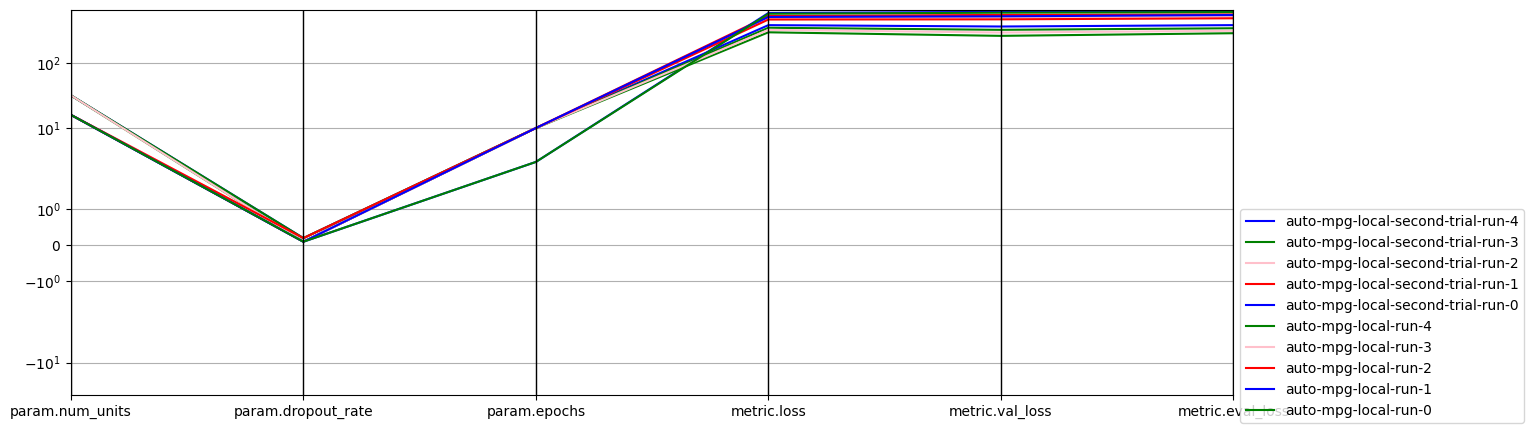

In [ ]:
plt.rcParams["figure.figsize"] = [15, 5]

ax = pd.plotting.parallel_coordinates(
    experiment_df.reset_index(level=0),
    "run_name",
    cols=[
        "param.num_units",
        "param.dropout_rate",
        "param.epochs",
        "metric.loss",
        "metric.val_loss",
        "metric.eval_loss",
    ],
    color=["blue", "green", "pink", "red"],
)
ax.set_yscale("symlog")
ax.legend(bbox_to_anchor=(1.0, 0.5))

# Visualize Experiment in Cloud Console

Print URL of Vertex AI Experiments for the project.

In [ ]:
print("Vertex AI Experiments")
print(f"https://console.cloud.google.com/ai/platform/experiments/experiments?rfolder=&organizationId=&project={PROJECT_ID}")

Vertex AI Experiments
https://console.cloud.google.com/ai/platform/experiments/experiments?rfolder=&organizationId=&project=ACTUAL_GOOGLE_PROJECT_ID
